# Multivariate TimeSeries Using Tensorflow

In [ ]:
#importing necessary libraries

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from sklearn.metrics import mean_squared_error

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.max_colwidth = 100

In [ ]:
#reading the csv file into pandas data frame
data = pd.read_csv("hd_gm_fixed.csv")
data

,STR_ALIAS,date_snap,weekly_sales_amt,weekly_shrink_amount,ty_net_shrink,ty_inv_sls,inv_cnt,cycle_length,FET_FLG,LU_FLG,urban,suburban,rural,rgn_nm,us_unemployment_rate_16_24,us_unemployment_rate,fyfw_prd_bgn,fyfw_prd_end,str_fet_wk_cnt,net_sls_amt,rtn_amt_rt,rtn_trans_rt,mkup_rt,rsn_01_rt,rsn_02_rt,dc_dmg_rt,str_dmg_rt,cust_sat_rt,rsn_06_rt,str_use_rt,rsn_09_rt,rdtag_rt,rsn_12_rt,rsn_15_rt,rsn_18_rt,rsn_22_rt,rsn_23_rt,rsn_24_rt,rsn_25_rt,promo_rt,...,inval_unt_intrvntn_rt,cash_pen,sco_pen,key_sku_rt,qty_key_rt,gen_sku_rt,d90_cash_vs_total,d90_sco_vs_total,d90_cash_vs_main,d90_sco_vs_main,attr_rt,quick_term_rt,avg_tenure,avg_wage,pt_ratio,int_cnt,int_val,ext_cnt,ext_val,known_theft_cnt,known_theft_val,merch_recov_cnt,merch_recov_val,pos_recov_cnt,pos_recov_val,risk_avt_cnt,risk_avt_val,lowes_flag,lowes_cnt,menards_flag,menards_cnt,avg_osha_rt,aci_score,cap_index,online_sat_voc_num,online_sat_voc_den,online_sat_voc_pct,zip_code,shrink_rate,state
0,1001,10/2/17,556736.78,10426.57,611648.84,32660070.09,3,55,0,1,0,1,0,MIDSOUTH,8.7,4.1,201635,201735,0,22038030.28,-0.149609,0.101869,0.009331,0.000324,0.000773,0.000211,0.007403,0.004279,0.000131,0.000503,0.009140,0.001536,0.001531,0.001433,0.000005,0.000058,0.001622,0.000765,0.001998,0.007829,...,0.250650,0.282240,0.110415,0.059294,0.034961,0.000064,0.418338,0.155321,0.729245,0.270755,0.010618,0.208333,5.412885,12.605000,0.633269,2,1844.75,7,7407.0,3,1800.00,18,12339.19,0,0.00,2,814.72,1,5,0,0,0.815405,0,0,164.08,193,0.850155,30096,0.018728,GA
1,1001,10/9/17,557228.39,10435.77,611648.84,32660070.09,3,55,0,1,0,1,0,MIDSOUTH,8.7,4.1,201636,201736,0,22559095.42,-0.150751,0.101917,0.009346,0.000317,0.000774,0.000221,0.007390,0.004273,0.000128,0.000549,0.009109,0.001554,0.001549,0.001440,0.000005,0.000057,0.001656,0.000755,0.002017,0.007692,...,0.250650,0.282114,0.110415,0.059323,0.034963,0.000069,0.418329,0.155359,0.729192,0.270808,0.010769,0.205479,5.411538,12.604808,0.633269,2,1844.75,7,7407.0,3,1800.00,18,12339.19,0,0.00,2,814.72,1,5,0,0,0.815405,0,0,164.23,193,0.850933,30096,0.018728,GA
2,1001,10/16/17,599390.85,11225.39,611648.84,32660070.09,3,55,0,1,0,1,0,MIDSOUTH,8.7,4.1,201637,201737,0,23073264.01,-0.151623,0.102010,0.009298,0.000313,0.000762,0.000221,0.007410,0.004266,0.000128,0.000548,0.009008,0.001568,0.001563,0.001447,0.000005,0.000055,0.001655,0.000755,0.002045,0.007553,...,0.250650,0.282093,0.110415,0.059364,0.034979,0.000068,0.419431,0.155190,0.729926,0.270074,0.010324,0.214286,5.407885,12.603462,0.633654,2,1844.75,7,7407.0,2,1042.00,17,11909.38,0,0.00,2,814.72,1,5,0,0,0.815405,0,0,163.67,193,0.848031,30096,0.018728,GA
3,1001,10/23/17,549696.03,10294.71,611648.84,32660070.09,3,55,0,1,0,1,0,MIDSOUTH,8.7,4.1,201638,201738,0,23634939.47,-0.151075,0.102063,0.009369,0.000319,0.000751,0.000216,0.007434,0.004222,0.000127,0.000549,0.008942,0.001559,0.001554,0.001446,0.000005,0.000072,0.001672,0.000741,0.002087,0.007423,...,0.250650,0.282017,0.110415,0.059451,0.034974,0.000064,0.419698,0.155206,0.730031,0.269969,0.010174,0.217391,5.406538,12.603269,0.634038,2,1844.75,7,7407.0,3,1301.00,18,12106.27,1,239.85,2,814.72,1,5,0,0,0.815405,0,0,162.96,191,0.853194,30096,0.018728,GA
4,1001,10/30/17,639228.97,11971.48,611648.84,32660070.09,3,55,0,1,0,1,0,MIDSOUTH,8.7,4.1,201639,201739,0,24155476.07,-0.151058,0.102077,0.009518,0.000380,0.000751,0.000220,0.007457,0.004198,0.000124,0.000551,0.008897,0.001535,0.001531,0.001463,0.000004,0.000071,0.001683,0.000735,0.002087,0.007440,...,0.250650,0.282124,0.110415,0.059494,0.034875,0.000061,0.420342,0.156345,0.728891,0.271109,0.010172,0.217391,5.405962,12.603269,0.634038,2,1844.75,7,7407.0,3,1301.00,19,12305.27,1,239.85,2,814.72,1,5,0,0,0.815405,0,0,161.74,189,0.855767,30096,0.018728,GA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [ ]:
#setting the Date column as the index of the data frame
data['date_snap'] = data['date_snap'].apply(pd.to_datetime)
data.set_index('date_snap',inplace=True)
x = data['weekly_shrink_amount']
data.drop(labels=['weekly_shrink_amount'], axis=1,inplace = True)
data.insert(0, 'weekly_shrink_amount', x)

In [ ]:
data

,weekly_shrink_amount,STR_ALIAS,weekly_sales_amt,ty_net_shrink,ty_inv_sls,inv_cnt,cycle_length,FET_FLG,LU_FLG,urban,suburban,rural,rgn_nm,us_unemployment_rate_16_24,us_unemployment_rate,fyfw_prd_bgn,fyfw_prd_end,str_fet_wk_cnt,net_sls_amt,rtn_amt_rt,rtn_trans_rt,mkup_rt,rsn_01_rt,rsn_02_rt,dc_dmg_rt,str_dmg_rt,cust_sat_rt,rsn_06_rt,str_use_rt,rsn_09_rt,rdtag_rt,rsn_12_rt,rsn_15_rt,rsn_18_rt,rsn_22_rt,rsn_23_rt,rsn_24_rt,rsn_25_rt,promo_rt,rsn_30_rt,...,inval_unt_intrvntn_rt,cash_pen,sco_pen,key_sku_rt,qty_key_rt,gen_sku_rt,d90_cash_vs_total,d90_sco_vs_total,d90_cash_vs_main,d90_sco_vs_main,attr_rt,quick_term_rt,avg_tenure,avg_wage,pt_ratio,int_cnt,int_val,ext_cnt,ext_val,known_theft_cnt,known_theft_val,merch_recov_cnt,merch_recov_val,pos_recov_cnt,pos_recov_val,risk_avt_cnt,risk_avt_val,lowes_flag,lowes_cnt,menards_flag,menards_cnt,avg_osha_rt,aci_score,cap_index,online_sat_voc_num,online_sat_voc_den,online_sat_voc_pct,zip_code,shrink_rate,state
date_snap,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-10-02,10426.57,1001,556736.78,611648.84,32660070.09,3,55,0,1,0,1,0,MIDSOUTH,8.7,4.1,201635,201735,0,22038030.28,-0.149609,0.101869,0.009331,0.000324,0.000773,0.000211,0.007403,0.004279,0.000131,0.000503,0.009140,0.001536,0.001531,0.001433,0.000005,0.000058,0.001622,0.000765,0.001998,0.007829,0.003467,...,0.250650,0.282240,0.110415,0.059294,0.034961,0.000064,0.418338,0.155321,0.729245,0.270755,0.010618,0.208333,5.412885,12.605000,0.633269,2,1844.75,7,7407.0,3,1800.00,18,12339.19,0,0.00,2,814.72,1,5,0,0,0.815405,0,0,164.08,193,0.850155,30096,0.018728,GA
2017-10-09,10435.77,1001,557228.39,611648.84,32660070.09,3,55,0,1,0,1,0,MIDSOUTH,8.7,4.1,201636,201736,0,22559095.42,-0.150751,0.101917,0.009346,0.000317,0.000774,0.000221,0.007390,0.004273,0.000128,0.000549,0.009109,0.001554,0.001549,0.001440,0.000005,0.000057,0.001656,0.000755,0.002017,0.007692,0.003403,...,0.250650,0.282114,0.110415,0.059323,0.034963,0.000069,0.418329,0.155359,0.729192,0.270808,0.010769,0.205479,5.411538,12.604808,0.633269,2,1844.75,7,7407.0,3,1800.00,18,12339.19,0,0.00,2,814.72,1,5,0,0,0.815405,0,0,164.23,193,0.850933,30096,0.018728,GA
2017-10-16,11225.39,1001,599390.85,611648.84,32660070.09,3,55,0,1,0,1,0,MIDSOUTH,8.7,4.1,201637,201737,0,23073264.01,-0.151623,0.102010,0.009298,0.000313,0.000762,0.000221,0.007410,0.004266,0.000128,0.000548,0.009008,0.001568,0.001563,0.001447,0.000005,0.000055,0.001655,0.000755,0.002045,0.007553,0.003382,...,0.250650,0.282093,0.110415,0.059364,0.034979,0.000068,0.419431,0.155190,0.729926,0.270074,0.010324,0.214286,5.407885,12.603462,0.633654,2,1844.75,7,7407.0,2,1042.00,17,11909.38,0,0.00,2,814.72,1,5,0,0,0.815405,0,0,163.67,193,0.848031,30096,0.018728,GA
2017-10-23,10294.71,1001,549696.03,611648.84,32660070.09,3,55,0,1,0,1,0,MIDSOUTH,8.7,4.1,201638,201738,0,23634939.47,-0.151075,0.102063,0.009369,0.000319,0.000751,0.000216,0.007434,0.004222,0.000127,0.000549,0.008942,0.001559,0.001554,0.001446,0.000005,0.000072,0.001672,0.000741,0.002087,0.007423,0.003405,...,0.250650,0.282017,0.110415,0.059451,0.034974,0.000064,0.419698,0.155206,0.730031,0.269969,0.010174,0.217391,5.406538,12.603269,0.634038,2,1844.75,7,7407.0,3,1301.00,18,12106.27,1,239.85,2,814.72,1,5,0,0,0.815405,0,0,162.96,191,0.853194,30096,0.018728,GA
2017-10-30,11971.48,1001,639228.97,611648.84,32660070.09,3,55,0,1,0,1,0,MIDSOUTH,8.7,4.1,201639,201739,0,24155476.07,-0.151058,0.102077,0.009518,0.000380,0.000751,0.000220,0.007457,0.004198,0.000124,0.000551,0.008897,0.001535,0.001531,0.001463,0.000004,0.000071,0.001683,0.000735,0.002087,0.007440,0.003440,...,0.250650,0.282124,0.110415,0.059494,0.034875,0.000061,0.420342,0.156345,0.728891,0.271109,0.010172,0.217391,5.405962,12.603269,0.634038,2,1844.75,7,7407.0,3,1301.00,19,12305.27,1,239.85,2,814.72,1,5,0,0,0.815405,0,0,161.74,189,0.855767,30096,0.018728,GA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [ ]:
#selecting only those rows, which has Region as 'CENTRAL'
df = data.loc[data['rgn_nm']=='CENTRAL']

In [ ]:
df.head()

,weekly_shrink_amount,STR_ALIAS,weekly_sales_amt,ty_net_shrink,ty_inv_sls,inv_cnt,cycle_length,FET_FLG,LU_FLG,urban,suburban,rural,rgn_nm,us_unemployment_rate_16_24,us_unemployment_rate,fyfw_prd_bgn,fyfw_prd_end,str_fet_wk_cnt,net_sls_amt,rtn_amt_rt,rtn_trans_rt,mkup_rt,rsn_01_rt,rsn_02_rt,dc_dmg_rt,str_dmg_rt,cust_sat_rt,rsn_06_rt,str_use_rt,rsn_09_rt,rdtag_rt,rsn_12_rt,rsn_15_rt,rsn_18_rt,rsn_22_rt,rsn_23_rt,rsn_24_rt,rsn_25_rt,promo_rt,rsn_30_rt,...,inval_unt_intrvntn_rt,cash_pen,sco_pen,key_sku_rt,qty_key_rt,gen_sku_rt,d90_cash_vs_total,d90_sco_vs_total,d90_cash_vs_main,d90_sco_vs_main,attr_rt,quick_term_rt,avg_tenure,avg_wage,pt_ratio,int_cnt,int_val,ext_cnt,ext_val,known_theft_cnt,known_theft_val,merch_recov_cnt,merch_recov_val,pos_recov_cnt,pos_recov_val,risk_avt_cnt,risk_avt_val,lowes_flag,lowes_cnt,menards_flag,menards_cnt,avg_osha_rt,aci_score,cap_index,online_sat_voc_num,online_sat_voc_den,online_sat_voc_pct,zip_code,shrink_rate,state
date_snap,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-02-06,5306.29,1695,401262.10,369874.89,27969203.9,4,55,0,0,0,1,0,CENTRAL,10.1,4.6,201601,201701,0,2144252.61,-0.127144,0.087304,0.010206,0.000258,0.000916,0.000890,0.008279,0.005063,0.000202,0.002054,0.020933,0.003653,0.003540,0.001073,0.000113,0.000929,0.004643,0.000458,0.001664,0.023535,0.008267,...,0.236401,0.265638,0.13595,0.057604,0.022388,0.000174,0.435454,0.138769,0.758336,0.241664,0.011916,0.161290,3.809615,12.522692,0.525192,1,57.21,1,248.98,5,1406.61,4,1316.49,0,0.0,1,388.0,1,2,1,1,1.557512,0,0,147.17,182,0.808626,62226,0.013224,IL
2017-02-13,5863.51,1695,443399.25,369874.89,27969203.9,4,55,0,0,0,1,0,CENTRAL,10.1,4.6,201602,201702,0,2541467.58,-0.132816,0.087479,0.009921,0.000389,0.000902,0.000786,0.007966,0.005026,0.000176,0.001815,0.018852,0.003378,0.003283,0.001277,0.000095,0.000792,0.004474,0.000503,0.001455,0.021416,0.008125,...,0.236401,0.265277,0.13595,0.057042,0.022856,0.000176,0.435300,0.138563,0.758543,0.241457,0.011912,0.161290,3.819231,12.539423,0.525962,1,57.21,1,248.98,5,1406.61,4,1316.49,0,0.0,1,388.0,1,2,1,1,1.557512,0,0,150.99,188,0.803138,62226,0.013224,IL
2017-02-20,6765.16,1695,511582.18,369874.89,27969203.9,4,55,0,0,0,1,0,CENTRAL,10.1,4.6,201603,201703,0,2979359.64,-0.127377,0.087550,0.009979,0.000374,0.001134,0.000682,0.007677,0.004845,0.000150,0.001591,0.017222,0.003249,0.003167,0.001271,0.000081,0.000676,0.004450,0.000519,0.001357,0.019718,0.007216,...,0.236401,0.264662,0.13595,0.056994,0.023444,0.000182,0.436416,0.137728,0.760115,0.239885,0.012488,0.153846,3.829038,12.550192,0.526346,1,57.21,1,248.98,5,1406.61,4,1316.49,0,0.0,1,388.0,1,2,1,1,1.557512,0,0,153.99,191,0.806230,62226,0.013224,IL
2017-02-27,6833.31,1695,516735.14,369874.89,27969203.9,4,55,0,0,0,1,0,CENTRAL,10.1,4.6,201604,201704,0,3483103.86,-0.125558,0.087582,0.013030,0.000337,0.001073,0.000645,0.007593,0.004816,0.000130,0.001465,0.016843,0.002940,0.002871,0.001192,0.000069,0.000578,0.004375,0.000481,0.001263,0.018318,0.006822,...,0.236401,0.263804,0.13595,0.057024,0.023483,0.000178,0.437521,0.137139,0.761356,0.238644,0.012670,0.151515,3.840000,12.560577,0.526154,1,57.21,1,248.98,5,1406.61,4,1316.49,0,0.0,1,388.0,1,2,1,1,1.557512,0,0,154.77,192,0.806094,62226,0.013224,IL
2017-03-06,6249.31,1695,472573.62,369874.89,27969203.9,4,55,0,0,0,1,0,CENTRAL,8.9,4.4,201605,201705,0,3995810.51,-0.127151,0.087484,0.012524,0.000327,0.001040,0.000594,0.007134,0.004859,0.000139,0.001316,0.016958,0.002805,0.002744,0.001149,0.000061,0.000504,0.004124,0.000457,0.001273,0.017076,0.006588,...,0.236401,0.263169,0.13595,0.057089,0.023445,0.000184,0.438268,0.136946,0.761922,0.238078,0.012666,0.151515,3.850385,12.570577,0.525769,1,57.21,1,248.98,4,1277.61,3,917.49,0,0.0,1,388.0,1,2,1,1,1.557512,0,0,159.85,199,0.803266,62226,0.013224,IL


In [ ]:
df.describe()

,weekly_shrink_amount,STR_ALIAS,weekly_sales_amt,ty_net_shrink,ty_inv_sls,inv_cnt,cycle_length,FET_FLG,LU_FLG,urban,suburban,rural,us_unemployment_rate_16_24,us_unemployment_rate,fyfw_prd_bgn,fyfw_prd_end,str_fet_wk_cnt,net_sls_amt,rtn_amt_rt,rtn_trans_rt,mkup_rt,rsn_01_rt,rsn_02_rt,dc_dmg_rt,str_dmg_rt,cust_sat_rt,rsn_06_rt,str_use_rt,rsn_09_rt,rdtag_rt,rsn_12_rt,rsn_15_rt,rsn_18_rt,rsn_22_rt,rsn_23_rt,rsn_24_rt,rsn_25_rt,promo_rt,rsn_30_rt,rsn_33_rt,...,inval_sls_intrvntn_rt,inval_unt_intrvntn_rt,cash_pen,sco_pen,key_sku_rt,qty_key_rt,gen_sku_rt,d90_cash_vs_total,d90_sco_vs_total,d90_cash_vs_main,d90_sco_vs_main,attr_rt,quick_term_rt,avg_tenure,avg_wage,pt_ratio,int_cnt,int_val,ext_cnt,ext_val,known_theft_cnt,known_theft_val,merch_recov_cnt,merch_recov_val,pos_recov_cnt,pos_recov_val,risk_avt_cnt,risk_avt_val,lowes_flag,lowes_cnt,menards_flag,menards_cnt,avg_osha_rt,aci_score,cap_index,online_sat_voc_num,online_sat_voc_den,online_sat_voc_pct,zip_code,shrink_rate
count,4910.000000,4910.000000,4.910000e+03,4.910000e+03,4.910000e+03,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4.910000e+03,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,...,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.00000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.0,4910.0,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000
mean,12875.233163,1996.259674,7.059695e+05,7.960894e+05,4.522430e+07,2.624033,65.688595,0.267821,0.319348,0.150102,0.625458,0.224440,9.743218,4.798391,201778.984725,201878.695316,5.348473,3.381797e+07,-0.147151,0.094157,0.013276,0.000791,0.000718,0.000091,0.005471,0.004887,0.000651,0.000483,0.017983,0.002094,0.002021,0.000757,0.000073,0.000439,0.002772,0.001366,0.002182,0.012954,0.011767,-0.000288,...,0.319838,0.275851,0.199463,0.141478,0.050798,0.027715,0.000676,0.449820,0.183206,0.710025,0.289975,0.010114,0.192171,5.088039,13.457882,0.552457,1.43442,1772.693067,16.534216,2873.646257,3.029532,1820.408434,7.462118,2850.914018,0.301426,115.532857,4.524236,1382.167670,0.894705,2.053157,0.872301,2.596334,1.640774,0.0,0.0,400.459711,471.892261,0.850799,60757.533401,0.018195
std,7104.345234,429.215393,2.498609e+05,4.239324e+05,1.718530e+07,0.852777,21.921408,0.442869,0.466272,0.357208,0.484054,0.417255,3.424326,2.378766,99.360350,99.225935,17.895596,1.148161e+07,0.018536,0.008422,0.004197,0.000526,0.000196,0.000109,0.001370,0.001347,0.000402,0.000159,0.006661,0.000776,0.000769,0.000502,0.000060,0.000536,0.001062,0.002044,0.002273,0.002192,0.007604,0.000206,...,0.028811,0.030114,0.069911,0.081264,0.015642,0.004056,0.000526,0.055525,0.045110,0.072496,0.072496,0.003004,0.083285,1.321196,1.924471,0.097276,1.80154,4487.758527,43.610528,6355.201470,6.548699,3520.127339,16.254736,5331.612446,0.912542,451.588907,15.109545,4071.527807,0.306965,1.317195,0.333788,2.002643,1.193319,0.0,0.0,187.774076,226.817605,0.033344,3073.390454,0.008594
min,1683.110000,1695.000000,2.266432e+05,2.733353e+05,2.238652e+07,1.000000,47.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.400000,3.500000,201601.000000,201701.000000,0.000000,2.040622e+06,-0.219320,0.070823,0.005784,-0.000348,0.000310,-0.000001,0.002648,0.002171,0.000032,0.000182,-0.094894,0.000459,0.000448,0.000152,-0.000006,-0.000127,0.001210,0.000357,0.000532,0.007027,0.002052,-0.001197,...,0.148539,0.068548,0.073992,0.000002,0.028851,0.011669,0.000025,0.309334,0.062795,0.524279,0.111897,0

In [ ]:
#check the quantity of null values in each columns
df.isnull().sum()

STR_ALIAS               0
weekly_sales_amt        0
weekly_shrink_amount    0
ty_net_shrink           0
ty_inv_sls              0
                       ..
online_sat_voc_pct      0
zip_code                0
shrink_rate             0
state                   0
DATE                    0
Length: 142, dtype: int64

In [ ]:
print(df.columns.tolist())

['STR_ALIAS', 'weekly_sales_amt', 'weekly_shrink_amount', 'ty_net_shrink', 'ty_inv_sls', 'inv_cnt', 'cycle_length', 'FET_FLG', 'LU_FLG', 'urban', 'suburban', 'rural', 'rgn_nm', 'us_unemployment_rate_16_24', 'us_unemployment_rate', 'fyfw_prd_bgn', 'fyfw_prd_end', 'str_fet_wk_cnt', 'net_sls_amt', 'rtn_amt_rt', 'rtn_trans_rt', 'mkup_rt', 'rsn_01_rt', 'rsn_02_rt', 'dc_dmg_rt', 'str_dmg_rt', 'cust_sat_rt', 'rsn_06_rt', 'str_use_rt', 'rsn_09_rt', 'rdtag_rt', 'rsn_12_rt', 'rsn_15_rt', 'rsn_18_rt', 'rsn_22_rt', 'rsn_23_rt', 'rsn_24_rt', 'rsn_25_rt', 'promo_rt', 'rsn_30_rt', 'rsn_33_rt', 'rsn_40_rt', 'rsn_41_rt', 'rsn_48_rt', 'rsn_49_rt', 'pc_rsn_24_rt', 'pc_rsn_25_rt', 'pc_rsn_27_rt', 'cull_mkdn_rt', 'rtv_crt_retl', 'rtv_del_retl', 'avg_inv_turns', 'yr_inv_turns', 'clear_inv_pct', 'ops_net_oh_unt_qty', 'ops_net_oh_retl_amt', 'theft_net_oh_unt_qty', 'theft_net_oh_retl_amt', 'net_oh_unt_qty', 'net_oh_retl_amt', 'net_adj_freq', 'neg_oh_unt_qty', 'neg_oh_retl_amt', 'neg_adj_freq', 'port_pwr_net_oh

In [ ]:
#fill the null rows with the mean of respective columns
# df = df.fillna(df.mean()) Not needed since HD supplied clean data

# Components of a Time Series

In [ ]:
df_1695 = df.loc[df['STR_ALIAS']==1695]
df_1695.head()

,weekly_shrink_amount,STR_ALIAS,weekly_sales_amt,ty_net_shrink,ty_inv_sls,inv_cnt,cycle_length,FET_FLG,LU_FLG,urban,suburban,rural,rgn_nm,us_unemployment_rate_16_24,us_unemployment_rate,fyfw_prd_bgn,fyfw_prd_end,str_fet_wk_cnt,net_sls_amt,rtn_amt_rt,rtn_trans_rt,mkup_rt,rsn_01_rt,rsn_02_rt,dc_dmg_rt,str_dmg_rt,cust_sat_rt,rsn_06_rt,str_use_rt,rsn_09_rt,rdtag_rt,rsn_12_rt,rsn_15_rt,rsn_18_rt,rsn_22_rt,rsn_23_rt,rsn_24_rt,rsn_25_rt,promo_rt,rsn_30_rt,...,inval_unt_intrvntn_rt,cash_pen,sco_pen,key_sku_rt,qty_key_rt,gen_sku_rt,d90_cash_vs_total,d90_sco_vs_total,d90_cash_vs_main,d90_sco_vs_main,attr_rt,quick_term_rt,avg_tenure,avg_wage,pt_ratio,int_cnt,int_val,ext_cnt,ext_val,known_theft_cnt,known_theft_val,merch_recov_cnt,merch_recov_val,pos_recov_cnt,pos_recov_val,risk_avt_cnt,risk_avt_val,lowes_flag,lowes_cnt,menards_flag,menards_cnt,avg_osha_rt,aci_score,cap_index,online_sat_voc_num,online_sat_voc_den,online_sat_voc_pct,zip_code,shrink_rate,state
date_snap,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-02-06,5306.29,1695,401262.10,369874.89,27969203.9,4,55,0,0,0,1,0,CENTRAL,10.1,4.6,201601,201701,0,2144252.61,-0.127144,0.087304,0.010206,0.000258,0.000916,0.000890,0.008279,0.005063,0.000202,0.002054,0.020933,0.003653,0.003540,0.001073,0.000113,0.000929,0.004643,0.000458,0.001664,0.023535,0.008267,...,0.236401,0.265638,0.13595,0.057604,0.022388,0.000174,0.435454,0.138769,0.758336,0.241664,0.011916,0.161290,3.809615,12.522692,0.525192,1,57.21,1,248.98,5,1406.61,4,1316.49,0,0.0,1,388.0,1,2,1,1,1.557512,0,0,147.17,182,0.808626,62226,0.013224,IL
2017-02-13,5863.51,1695,443399.25,369874.89,27969203.9,4,55,0,0,0,1,0,CENTRAL,10.1,4.6,201602,201702,0,2541467.58,-0.132816,0.087479,0.009921,0.000389,0.000902,0.000786,0.007966,0.005026,0.000176,0.001815,0.018852,0.003378,0.003283,0.001277,0.000095,0.000792,0.004474,0.000503,0.001455,0.021416,0.008125,...,0.236401,0.265277,0.13595,0.057042,0.022856,0.000176,0.435300,0.138563,0.758543,0.241457,0.011912,0.161290,3.819231,12.539423,0.525962,1,57.21,1,248.98,5,1406.61,4,1316.49,0,0.0,1,388.0,1,2,1,1,1.557512,0,0,150.99,188,0.803138,62226,0.013224,IL
2017-02-20,6765.16,1695,511582.18,369874.89,27969203.9,4,55,0,0,0,1,0,CENTRAL,10.1,4.6,201603,201703,0,2979359.64,-0.127377,0.087550,0.009979,0.000374,0.001134,0.000682,0.007677,0.004845,0.000150,0.001591,0.017222,0.003249,0.003167,0.001271,0.000081,0.000676,0.004450,0.000519,0.001357,0.019718,0.007216,...,0.236401,0.264662,0.13595,0.056994,0.023444,0.000182,0.436416,0.137728,0.760115,0.239885,0.012488,0.153846,3.829038,12.550192,0.526346,1,57.21,1,248.98,5,1406.61,4,1316.49,0,0.0,1,388.0,1,2,1,1,1.557512,0,0,153.99,191,0.806230,62226,0.013224,IL
2017-02-27,6833.31,1695,516735.14,369874.89,27969203.9,4,55,0,0,0,1,0,CENTRAL,10.1,4.6,201604,201704,0,3483103.86,-0.125558,0.087582,0.013030,0.000337,0.001073,0.000645,0.007593,0.004816,0.000130,0.001465,0.016843,0.002940,0.002871,0.001192,0.000069,0.000578,0.004375,0.000481,0.001263,0.018318,0.006822,...,0.236401,0.263804,0.13595,0.057024,0.023483,0.000178,0.437521,0.137139,0.761356,0.238644,0.012670,0.151515,3.840000,12.560577,0.526154,1,57.21,1,248.98,5,1406.61,4,1316.49,0,0.0,1,388.0,1,2,1,1,1.557512,0,0,154.77,192,0.806094,62226,0.013224,IL
2017-03-06,6249.31,1695,472573.62,369874.89,27969203.9,4,55,0,0,0,1,0,CENTRAL,8.9,4.4,201605,201705,0,3995810.51,-0.127151,0.087484,0.012524,0.000327,0.001040,0.000594,0.007134,0.004859,0.000139,0.001316,0.016958,0.002805,0.002744,0.001149,0.000061,0.000504,0.004124,0.000457,0.001273,0.017076,0.006588,...,0.236401,0.263169,0.13595,0.057089,0.023445,0.000184,0.438268,0.136946,0.761922,0.238078,0.012666,0.151515,3.850385,12.570577,0.525769,1,57.21,1,248.98,4,1277.61,3,917.49,0,0.0,1,388.0,1,2,1,1,1.557512,0,0,159.85,199,0.803266,62226,0.013224,IL


In [ ]:
df_1695['fyfw_prd_bgn'].dtypes

dtype('int64')

In [ ]:
df_1695.columns[0]

'weekly_shrink_amount'

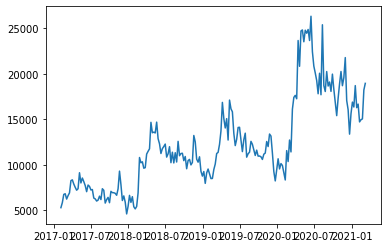

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plt.plot(df_1695['weekly_shrink_amount'])
plt.show()


Text(0.5, 1.0, 'weekly_shrink_amount')

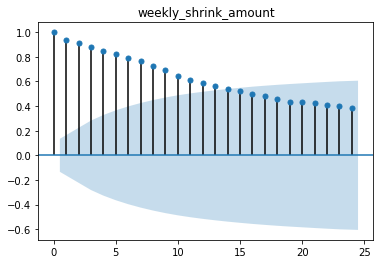

In [ ]:
plot_acf(df_1695['weekly_shrink_amount'])
plt.title('weekly_shrink_amount')

In [ ]:
# Autocorrelation
# An autocorrelation function measures the degree of similarity of the present series with that of its lagged series (past values). 
# The ACF graph for the AQI index shows spike above the blue region, which is an indication that the series is autocorrelated.
# It means the correlation of the present values with its past values.

In [ ]:
df_1695_drop = df_1695.drop(columns=['STR_ALIAS','state','rgn_nm','fyfw_prd_bgn','fyfw_prd_end'])
df_1695_drop

,weekly_shrink_amount,weekly_sales_amt,ty_net_shrink,ty_inv_sls,inv_cnt,cycle_length,FET_FLG,LU_FLG,urban,suburban,rural,us_unemployment_rate_16_24,us_unemployment_rate,str_fet_wk_cnt,net_sls_amt,rtn_amt_rt,rtn_trans_rt,mkup_rt,rsn_01_rt,rsn_02_rt,dc_dmg_rt,str_dmg_rt,cust_sat_rt,rsn_06_rt,str_use_rt,rsn_09_rt,rdtag_rt,rsn_12_rt,rsn_15_rt,rsn_18_rt,rsn_22_rt,rsn_23_rt,rsn_24_rt,rsn_25_rt,promo_rt,rsn_30_rt,rsn_33_rt,rsn_40_rt,rsn_41_rt,rsn_48_rt,...,inval_sls_intrvntn_rt,inval_unt_intrvntn_rt,cash_pen,sco_pen,key_sku_rt,qty_key_rt,gen_sku_rt,d90_cash_vs_total,d90_sco_vs_total,d90_cash_vs_main,d90_sco_vs_main,attr_rt,quick_term_rt,avg_tenure,avg_wage,pt_ratio,int_cnt,int_val,ext_cnt,ext_val,known_theft_cnt,known_theft_val,merch_recov_cnt,merch_recov_val,pos_recov_cnt,pos_recov_val,risk_avt_cnt,risk_avt_val,lowes_flag,lowes_cnt,menards_flag,menards_cnt,avg_osha_rt,aci_score,cap_index,online_sat_voc_num,online_sat_voc_den,online_sat_voc_pct,zip_code,shrink_rate
date_snap,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-02-06,5306.29,401262.10,369874.89,27969203.9,4,55,0,0,0,1,0,10.1,4.6,0,2144252.61,-0.127144,0.087304,0.010206,0.000258,0.000916,0.000890,0.008279,0.005063,0.000202,0.002054,0.020933,0.003653,0.003540,0.001073,0.000113,0.000929,0.004643,0.000458,0.001664,0.023535,0.008267,-0.000018,0.005349,0.000869,5.000000e-07,...,0.298964,0.236401,0.265638,0.135950,0.057604,0.022388,0.000174,0.435454,0.138769,0.758336,0.241664,0.011916,0.161290,3.809615,12.522692,0.525192,1,57.21,1,248.98,5,1406.61,4,1316.49,0,0.0,1,388.0,1,2,1,1,1.557512,0,0,147.17,182,0.808626,62226,0.013224
2017-02-13,5863.51,443399.25,369874.89,27969203.9,4,55,0,0,0,1,0,10.1,4.6,0,2541467.58,-0.132816,0.087479,0.009921,0.000389,0.000902,0.000786,0.007966,0.005026,0.000176,0.001815,0.018852,0.003378,0.003283,0.001277,0.000095,0.000792,0.004474,0.000503,0.001455,0.021416,0.008125,-0.000027,0.005324,0.000750,4.000000e-07,...,0.298964,0.236401,0.265277,0.135950,0.057042,0.022856,0.000176,0.435300,0.138563,0.758543,0.241457,0.011912,0.161290,3.819231,12.539423,0.525962,1,57.21,1,248.98,5,1406.61,4,1316.49,0,0.0,1,388.0,1,2,1,1,1.557512,0,0,150.99,188,0.803138,62226,0.013224
2017-02-20,6765.16,511582.18,369874.89,27969203.9,4,55,0,0,0,1,0,10.1,4.6,0,2979359.64,-0.127377,0.087550,0.009979,0.000374,0.001134,0.000682,0.007677,0.004845,0.000150,0.001591,0.017222,0.003249,0.003167,0.001271,0.000081,0.000676,0.004450,0.000519,0.001357,0.019718,0.007216,-0.000023,0.005377,0.000640,3.200000e-06,...,0.298964,0.236401,0.264662,0.135950,0.056994,0.023444,0.000182,0.436416,0.137728,0.760115,0.239885,0.012488,0.153846,3.829038,12.550192,0.526346,1,57.21,1,248.98,5,1406.61,4,1316.49,0,0.0,1,388.0,1,2,1,1,1.557512,0,0,153.99,191,0.806230,62226,0.013224
2017-02-27,6833.31,516735.14,369874.89,27969203.9,4,55,0,0,0,1,0,10.1,4.6,0,3483103.86,-0.125558,0.087582,0.013030,0.000337,0.001073,0.000645,0.007593,0.004816,0.000130,0.001465,0.016843,0.002940,0.002871,0.001192,0.000069,0.000578,0.004375,0.000481,0.001263,0.018318,0.006822,-0.000034,0.005684,0.000858,2.700000e-06,...,0.298964,0.236401,0.263804,0.135950,0.057024,0.023483,0.000178,0.437521,0.137139,0.761356,0.238644,0.012670,0.151515,3.840000,12.560577,0.526154,1,57.21,1,248.98,5,1406.61,4,1316.49,0,0.0,1,388.0,1,2,1,1,1.557512,0,0,154.77,192,0.806094,62226,0.013224
2017-03-06,6249.31,472573.62,369874.89,27969203.9,4,55,0,0,0,1,0,8.9,4.4,0,3995810.51,-0.127151,0.087484,0.012524,0.000327,0.001040,0.000594,0.007134,0.004859,0.000139,0.001316,0.016958,0.002805,0.002744,0.001149,0.000061,0.000504,0.004124,0.000457,0.001273,0.017076,0.006588,-0.000028,0.005677,0.000754,2.700000e-06,...,0.298964,0.236401,0.263169,0.135950,0.057089,0.023445,0.000184,0.438268,0.136946,0.761922,0.238078,0.012666,0.151515,3.850385,12.570577,0.525769,1,57.21,1,248.98,4,1277.61,3,917.49,0,0.0,1,388.0,1,2,1,1,1.557512,0,0,159.85,199,0.803266,62226,0.013224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [ ]:
np.savetxt(r'np.txt', df_1695_drop.values, fmt='%f', delimiter =',')

In [ ]:
len(df_1695)

213

In [ ]:
#We will use it further to show the graph of multi step prediction
df_train = df_1695_drop.iloc[0:170]
df_test = df_1695_drop.iloc[170:]

In [ ]:
# from statsmodels.tsa.vector_ar.vecm import coint_johansen

# johan_test = df_1695_drop
# coint_johansen(johan_test,-1,1).eig

#https://neeva.com/search?q=---%3E+88+raise+LinAlgError(%22Singular+matrix%22)&src=nvobar#animatedtechdoc-https%3A%2F%2Fstackoverflow.com%2Fquestions%2F44305456%2Fwhy-am-i-getting-linalgerror-singular-matrix-from-grangercausalitytests-https%3A%2F%2Fstackoverflow.com%2Fquestions%2F44305456%2Fwhy-am-i-getting-linalgerror-singular-matrix-from-grangercausalitytests%23825367011208 

# LSTM

# Data preparation


In [ ]:
#scale the values
df_1695_drop = df_1695_drop.values
scaler = MinMaxScaler(feature_range=(0, 1))
df_1695_drop = scaler.fit_transform(df_1695_drop)

In [ ]:
print(df_1695_drop)

[[0.03161159 0.07719849 0.         ... 0.09747269 0.         0.        ]
 [0.05729785 0.139927   0.         ... 0.02171492 0.         0.        ]
 [0.09886135 0.24142919 0.         ... 0.06439803 0.         0.        ]
 ...
 [0.48072562 0.34923396 1.         ... 0.06854265 0.         1.        ]
 [0.62678863 0.53228296 1.         ... 0.08801933 0.         1.        ]
 [0.66046537 0.57448771 1.         ... 0.07100321 0.         1.        ]]


In [ ]:
#divide the data into train and test data
train_size = int(len(df_1695_drop) * 0.80)
test_size = len(df_1695_drop) - train_size
train, test = df_1695_drop[0:train_size,:], df_1695_drop[train_size:len(df_1695_drop),:]

In [ ]:
#index the data into dependent and independent variables
train_X, train_y = train[:, 1:], train[:, 0]
test_X, test_y = test[:, 1:], test[:, 0]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(170, 135) (170,) (43, 135) (43,)


In [ ]:
#convert data into suitable dimension for using it as input in LSTM network
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(170, 1, 135) (170,) (43, 1, 135) (43,)


In [ ]:
model = Sequential()
model.add(LSTM(250, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [ ]:
history = model.fit(train_X, train_y, epochs=250, batch_size=85, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/250
2/2 - 2s - loss: 0.2144 - val_loss: 0.1161
Epoch 2/250
2/2 - 0s - loss: 0.2705 - val_loss: 0.1035
Epoch 3/250
2/2 - 0s - loss: 0.2326 - val_loss: 0.2056
Epoch 4/250
2/2 - 0s - loss: 0.1370 - val_loss: 0.3649
Epoch 5/250
2/2 - 0s - loss: 0.1745 - val_loss: 0.3304
Epoch 6/250
2/2 - 0s - loss: 0.1377 - val_loss: 0.1737
Epoch 7/250
2/2 - 0s - loss: 0.0950 - val_loss: 0.1016
Epoch 8/250
2/2 - 0s - loss: 0.1231 - val_loss: 0.1080
Epoch 9/250
2/2 - 0s - loss: 0.1168 - val_loss: 0.1013
Epoch 10/250
2/2 - 0s - loss: 0.0782 - val_loss: 0.1175
Epoch 11/250
2/2 - 0s - loss: 0.0906 - val_loss: 0.1179
Epoch 12/250
2/2 - 0s - loss: 0.0970 - val_loss: 0.1003
Epoch 13/250
2/2 - 0s - loss: 0.0883 - val_loss: 0.1051
Epoch 14/250
2/2 - 0s - loss: 0.0860 - val_loss: 0.1067
Epoch 15/250
2/2 - 0s - loss: 0.0817 - val_loss: 0.0971
Epoch 16/250
2/2 - 0s - loss: 0.0703 - val_loss: 0.0959
Epoch 17/250
2/2 - 0s - loss: 0.0731 - val_loss: 0.0951
Epoch 18/250
2/2 - 0s - loss: 0.0719 - val_loss: 0.1007
E

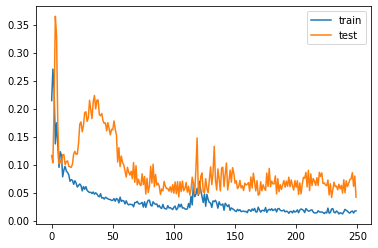

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
#prediction on training and testing data
train_predict = model.predict(train_X)    
test_predict = model.predict(test_X)

In [ ]:
train_predict.shape
#test_predict.shape
#train_X.shape

(170, 1)

In [ ]:
#converting from three dimension to two dimension
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
print(train_X.shape)

(170, 135)


In [ ]:
inv_train_predict = concatenate((train_predict, train_X), axis=1)
inv_test_predict = concatenate((test_predict, test_X), axis=1)

In [ ]:
#transforming to original scale
inv_train_predict = scaler.inverse_transform(inv_train_predict)
inv_test_predict = scaler.inverse_transform(inv_test_predict)

In [ ]:
#predicted values on training data
inv_train_predict = inv_train_predict[:,0]
inv_train_predict

array([ 5238.32425146,  5731.44685362,  6501.34692415,  6569.71998991,
        6081.4818189 ,  6549.89392139,  6914.87298886,  8129.29657976,
        8070.33542141,  7563.80793857,  7347.3702729 ,  7041.17974534,
        7198.36596922,  8930.98317265,  7784.91567659,  8311.39061038,
        7908.94105732,  7570.61311355,  6912.62814098,  7570.2610883 ,
        7403.08885524,  7061.42216695,  7103.09594394,  6229.85933015,
        6105.60169034,  5812.50398067,  5978.23417091,  6368.67979227,
        5938.44578168,  7187.8323652 ,  6916.32860842,  5515.80762905,
        6015.95825045,  6277.72458153,  5678.33468044,  6966.79364223,
        6820.95384836,  6751.00668989,  6749.09754286,  6358.91666776,
        7143.21308401,  9268.58540779,  7598.63742666,  5774.48266769,
        6277.76272568,  5663.71011633,  4299.72686878,  5148.95917497,
        6577.70407773,  5694.07431444,  6355.79369628,  5206.77770592,
        4912.49364853,  5251.40555337,  7004.74561691,  9907.5762099 ,
      

In [ ]:
#predicted values on testing data
inv_test_predict = inv_test_predict[:,0]
inv_test_predict

array([23959.46409914, 23776.98765725, 24149.91848699, 23190.56337302,
       25003.14105919, 22139.41403862, 20958.36124532, 20295.25558223,
       19589.19443406, 18692.79914909, 20450.45572426, 18632.02582035,
       24171.54945264, 19367.62476392, 18900.25677672, 20537.06234026,
       19275.9533806 , 19578.6821649 , 18903.34580637, 20180.02792344,
       19006.64792291, 18030.59084329, 16978.61009572, 18263.60117241,
       19458.84488256, 20352.50542592, 19280.25397189, 19935.1282567 ,
       21696.33288433, 18294.16562731, 17569.96984508, 15605.27328839,
       17405.8594882 , 18270.08826397, 17649.89541622, 19314.38328854,
       17754.98578224, 18240.67201263, 16887.22447027, 16962.07105085,
       17039.77521014, 19106.17441511, 19390.87976525])

In [ ]:
#scaling back the original train labels
train_y = train_y.reshape((len(train_y), 1))
print(train_y.shape)
inv_train_y = concatenate((train_y, train_X), axis=1)
inv_train_y = scaler.inverse_transform(inv_train_y)
inv_train_y = inv_train_y[:,0]

(170, 1)


In [ ]:
#scaling back the original test labels
test_y = test_y.reshape((len(test_y), 1))
inv_test_y = concatenate((test_y, test_X), axis=1)
inv_test_y = scaler.inverse_transform(inv_test_y)
inv_test_y = inv_test_y[:,0]

In [ ]:
#calculating rmse on train data
rmse_train = sqrt(mean_squared_error(inv_train_y, inv_train_predict))
print('Test RMSE: %.3f' % rmse_train)

Test RMSE: 433.924


In [ ]:
#calculating rmse on test data
rmse_test = sqrt(mean_squared_error(inv_test_y, inv_test_predict))
print('Test RMSE: %.3f' % rmse_test)

Test RMSE: 1078.222


In [ ]:
#plotting the graph of test actual vs predicted
inv_test_y = inv_test_y.reshape(-1,1)
inv_test_y.shape

(43, 1)

In [ ]:
t = np.arange(0,43,1)


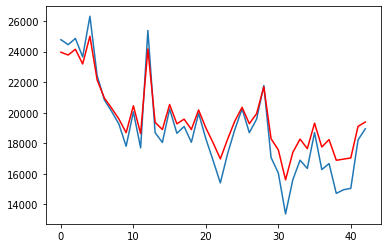

In [ ]:
plt.plot(t,inv_test_y,label="actual")
plt.plot(t,inv_test_predict,'r',label="predicted")
plt.show()

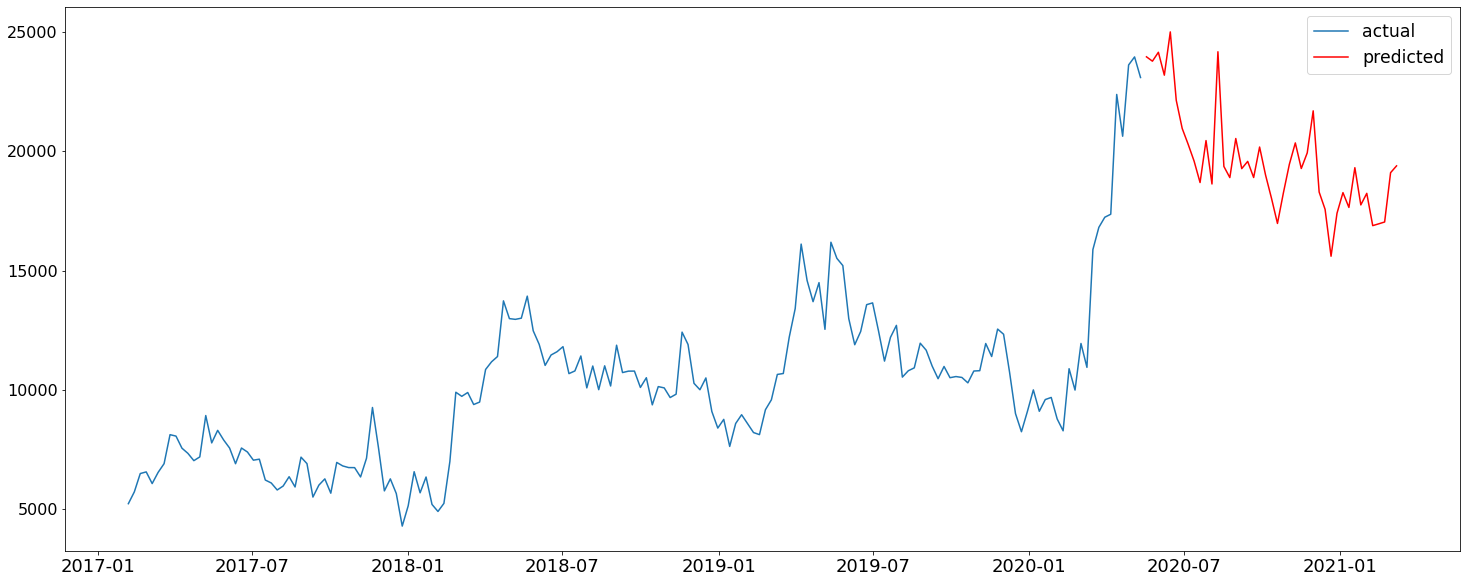

In [ ]:
#plotting the graph to show multi step prediction
plt.figure(figsize=(25, 10))
plt.plot(df_train.index, inv_train_predict,label="actual")
plt.plot(df_test.index, inv_test_predict, color='r',label="predicted")
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

In [ ]:
len(df_test), len(df_train)

(43, 170)

In [ ]:
import xgboost
import shap

# train an XGBoost model
X, y = shap.datasets.boston()
model = xgboost.XGBRegressor().fit(X, y)


In [ ]:

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X)

In [ ]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [ ]:
a = np.array([[14, 8, 11, 10], [7, 9, 10, 11], [10, 15, 5, 10]])
#np.std(a)
a.mean()
a= abs(a-a.mean())**2
a= a.mean()
a

6.833333333333333

In [ ]:
std = sqrt(mean(x)), where x = abs(a - a.mean())**2.